# KMeans Clustering on HBN Data

This notebook performs KMeans clustering on Executive Function (EF) and Temporal Discounting (TD) measures from the Healthy Brain Network dataset.

**Analysis Pipeline:**
1. Load and prepare data
2. Impute missing values (median)
3. Standardize features (z-scoring)
4. Fit KMeans clustering
5. Profile clusters (demographics + features)
6. Visualize results
7. Save essential results

## 1. Setup and Data Loading

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

plt.rcParams['figure.dpi'] = 160
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
DATA_PATH = Path("data/processed/hbn_core_view_v1.csv")
df = pd.read_csv(DATA_PATH)

print(f"Data loaded: {df.shape[0]} participants, {df.shape[1]} features")
print(f"\nFirst few rows:")
df.head()

Data loaded: 1975 participants, 27 features

First few rows:


,Age,"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_Flanker_Computed_Score","NIH_final,NIH_Flanker_Inst_Breakoff","NIH_final,NIH_Flanker_Inst_Status","NIH_final,NIH_Flanker_Itm_Cnt","NIH_final,NIH_Flanker_Raw","NIH_final,NIH_Flanker_Uncorr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Inst_Breakoff",...,"NIH_final,NIH_Processing_Inst_Status","NIH_final,NIH_Processing_Itm_Cnt","NIH_final,NIH_Processing_Raw","NIH_final,NIH_Processing_Uncorr_Stnd",Sex,_EID,k_abs_diff_log,k_cv,k_gmean,logk_mean
0,21.216746,70.0,7.66,2.0,3.0,24.0,20.0,94.0,59.0,1.0,...,3.0,36.0,32.0,76.0,1.0,NDARAA306NT2,0.000000,0.000000,0.000110,-9.119458
1,9.165297,78.0,6.34,2.0,3.0,24.0,20.0,80.0,82.0,1.0,...,3.0,29.0,27.0,65.0,1.0,NDARAA504CRN,4.952615,1.971939,0.003324,-5.706448
2,10.793862,83.0,7.39,2.0,3.0,24.0,20.0,91.0,100.0,2.0,...,3.0,41.0,39.0,90.0,1.0,NDARAB055BPR,0.936703,0.873733,0.000175,-8.651107
3,5.805384,111.0,5.19,2.0,3.0,44.0,40.0,69.0,109.0,2.0,...,3.0,15.0,15.0,49.0,0.0,NDARAB348EWR,1.556754,1.303548,0.000281,-8.176825
4,5.055213,99.0,4.63,2.0,3.0,44.0,37.0,63.0,75.0,1.0,...,3.0,28.0,21.0,57.0,0.0,NDARAB514MAJ,0.000000,0.000000,24.000000,3.178054


## 2. Define Features for Clustering

We'll cluster on:
- **Executive Function (EF)**: Age-corrected scores from NIH Toolbox
  - Flanker (inhibitory control)
  - List Sorting (working memory)  
  - Processing Speed
- **Temporal Discounting (TD)**: Delay discounting measures
  - logk_mean (average discount rate)
  - k_abs_diff_log (consistency between runs)

In [3]:
# Define clustering features
CLUSTERING_FEATURES = [
    "NIH_final,NIH_Flanker_Age_Corr_Stnd",      # EF: Inhibitory control
    "NIH_final,NIH_List_Sort_Age_Corr_Stnd",    # EF: Working memory
    "NIH_final,NIH_Processing_Age_Corr_Stnd",   # EF: Processing speed
    "logk_mean",                                 # TD: Discount rate
    "k_abs_diff_log"                            # TD: Consistency
]

# Demographics for profiling (not used in clustering)
DEMOGRAPHICS = ["Age", "Sex"]

print(f"Clustering on {len(CLUSTERING_FEATURES)} features:")
for i, feat in enumerate(CLUSTERING_FEATURES, 1):
    print(f"  {i}. {feat}")

Clustering on 5 features:
  1. NIH_final,NIH_Flanker_Age_Corr_Stnd
  2. NIH_final,NIH_List_Sort_Age_Corr_Stnd
  3. NIH_final,NIH_Processing_Age_Corr_Stnd
  4. logk_mean
  5. k_abs_diff_log


In [4]:
# Check data availability
X = df[CLUSTERING_FEATURES].copy()
demo = df[DEMOGRAPHICS].copy()

# Feature missingness
missing_pct = X.isna().mean() * 100
for feat, pct in missing_pct.items():
    status = "✓" if pct < 10 else "⚠️"
    print(f"{status} {feat.split(',')[-1]:30s} {pct:5.1f}% missing")

print(f"\nTotal participants with any data: {(~X.isna().all(axis=1)).sum()}")

✓ NIH_Flanker_Age_Corr_Stnd        0.0% missing
✓ NIH_List_Sort_Age_Corr_Stnd      0.0% missing
✓ NIH_Processing_Age_Corr_Stnd     0.0% missing
✓ logk_mean                        0.0% missing
✓ k_abs_diff_log                   3.4% missing

Total participants with any data: 1975


## 3. Preprocessing: Imputation and Scaling

**Steps:**
1. **Median Imputation**: Fill missing values with column medians
2. **Z-Score Standardization**: Scale to mean=0, std=1 for clustering

*(Note: Demographics are NOT used for clustering, only for profiling)*

In [5]:
# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit and transform the data
X_scaled = preprocessor.fit_transform(X)

print(f"  - Imputed missing values: {X.isna().sum().sum()} cells")
print(f"  - Scaled data shape: {X_scaled.shape}")
print(f"  - Feature means (should be ~0): {X_scaled.mean(axis=0).round(3)}")
print(f"  - Feature stds (should be ~1): {X_scaled.std(axis=0).round(3)}")

  - Imputed missing values: 67 cells
  - Scaled data shape: (1975, 5)
  - Feature means (should be ~0): [-0. -0.  0.  0.  0.]
  - Feature stds (should be ~1): [1. 1. 1. 1. 1.]


## 4. Fit KMeans Clustering

We'll fit KMeans with different numbers of clusters (k=2 to 5) and select the best using silhouette score.

In [6]:
# Try different values of k
k_values = [2, 3, 4, 5]
results = []

for k in k_values:
    # Fit KMeans
    kmeans = KMeans(
        n_clusters=k,
        n_init=20,           # Try 20 different initializations
        random_state=42,     # For reproducibility
        max_iter=300
    )
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_scaled, labels)
    
    # Store results
    results.append({
        'k': k,
        'silhouette': sil_score,
        'inertia': kmeans.inertia_,
        'model': kmeans,
        'labels': labels
    })
    
    print(f"k={k}: silhouette={sil_score:.3f}, inertia={kmeans.inertia_:.1f}")

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)

k=2: silhouette=0.178, inertia=7961.2
k=3: silhouette=0.166, inertia=6863.8
k=4: silhouette=0.183, inertia=5963.2
k=5: silhouette=0.174, inertia=5477.8


In [7]:
# Select best k (highest silhouette score)
best_idx = results_df['silhouette'].idxmax()
best_k = results_df.loc[best_idx, 'k']
best_model = results_df.loc[best_idx, 'model']
best_labels = results_df.loc[best_idx, 'labels']
best_sil = results_df.loc[best_idx, 'silhouette']

print(f"SELECTED MODEL: k={best_k}")
print(f"Silhouette Score: {best_sil:.3f}")
print(f"Cluster sizes: {pd.Series(best_labels).value_counts().sort_index().to_dict()}")

SELECTED MODEL: k=4
Silhouette Score: 0.183
Cluster sizes: {0: 512, 1: 587, 2: 340, 3: 536}


## 5. Cluster Profiles

We'll create two profile views:

1. **Demographics** (Age, Sex) in **original units**
   - Age in years
   - Sex as % Male

2. **Features** (EF + TD) as **population z-scores**
   - Standardized relative to full sample
   - Shows how each cluster differs from population mean

**Interpretation:**
- z = 0: Cluster mean equals population mean
- z > 0: Cluster mean is above population mean
- z < 0: Cluster mean is below population mean
- |z| > 0.5: Moderate effect
- |z| > 1.0: Large effect

In [8]:
# Prepare data for profiling
profile_df = df[CLUSTERING_FEATURES + DEMOGRAPHICS].copy()
profile_df['Cluster'] = best_labels

# Normalize Sex to 0/1 if needed
if profile_df['Sex'].dtype == object:
    profile_df['Sex'] = (profile_df['Sex'].astype(str).str.lower()
                         .map({'male': 1, 'm': 1, 'female': 0, 'f': 0}))
else:
    profile_df['Sex'] = pd.to_numeric(profile_df['Sex'], errors='coerce')

In [9]:
# Calculate demographic means by cluster
demo_profile = profile_df.groupby('Cluster').agg({
    'Age': 'mean',
    'Sex': 'mean'  # Proportion male (will convert to %)
}).round(2)

# Convert Sex to percentage Male
demo_profile['Sex (% Male)'] = (demo_profile['Sex'] * 100).round(1)
demo_profile = demo_profile.drop(columns=['Sex'])
demo_profile = demo_profile.rename(columns={'Age': 'Age (years)'})

# Add cluster sizes
demo_profile['N'] = profile_df['Cluster'].value_counts().sort_index()

In [10]:
# Calculate population z-scores for features
feature_data = profile_df[CLUSTERING_FEATURES].copy()

# Standardize to population (full sample)
feature_z = (feature_data - feature_data.mean()) / feature_data.std()
feature_z['Cluster'] = profile_df['Cluster']

# Calculate mean z-scores by cluster
feature_profile = feature_z.groupby('Cluster').mean()

# Simplify column names for display
feature_profile.columns = [
    col.split(',')[-1].replace('_', ' ') if ',' in col else col.replace('_', ' ')
    for col in feature_profile.columns
]

In [11]:
# Combine demographics and features
combined_profile = pd.concat([demo_profile, feature_profile], axis=1)

display(combined_profile.style.format({
    'Age (years)': '{:.1f}',
    'Sex (% Male)': '{:.1f}%',
    'N': '{:.0f}'
}).background_gradient(cmap='RdBu_r', subset=feature_profile.columns, vmin=-2, vmax=2))

,Age (years),Sex (% Male),N,NIH Flanker Age Corr Stnd,NIH List Sort Age Corr Stnd,NIH Processing Age Corr Stnd,logk mean,k abs diff log
Cluster,,,,,,,,
0,10.7,32.0%,512,-0.502802,-0.395828,-0.352145,0.989330,-0.377268
1,11.0,33.0%,587,0.761772,0.795188,0.895119,-0.043357,-0.182453
2,9.8,31.0%,340,-0.126750,-0.343097,-0.358201,0.132400,1.628782
3,10.1,39.0%,536,-0.273565,-0.275109,-0.416694,-0.981535,-0.518413


## 6. Visualizations

We'll create several visualizations to inspect the clusters:

1. **PCA Scatter Plot**: 2D projection of clusters
2. **Silhouette Plot**: Quality of cluster assignments
3. **Profile Heatmap**: Visual comparison of cluster characteristics
4. **Feature Distributions**: Distribution of each feature by cluster
5. **Cluster Size Bar Chart**: Number of participants per cluster

### 6.1 PCA Scatter Plot

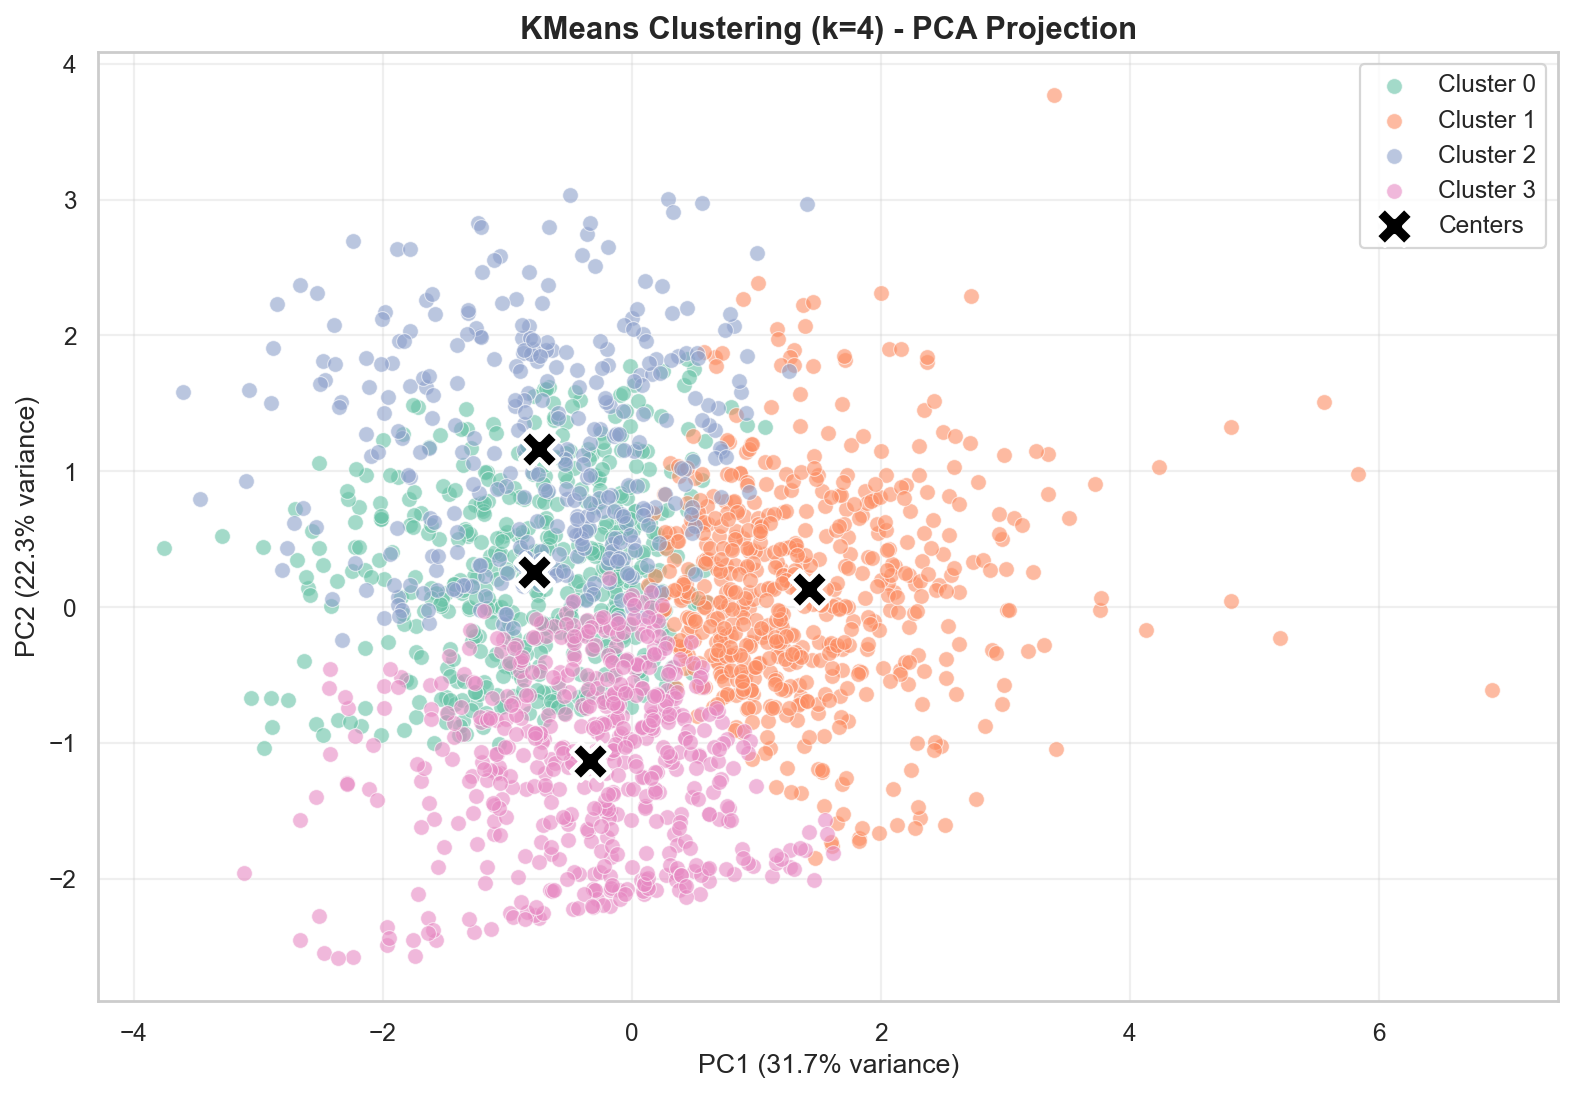

PCA explains 54.0% of variance with 2 components


In [12]:
# Perform PCA for visualization (2D projection)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each cluster
colors = sns.color_palette('Set2', n_colors=best_k)
for i in range(best_k):
    mask = best_labels == i
    ax.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1],
        c=[colors[i]], 
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='white',
        linewidth=0.5
    )

# Plot cluster centers (transform to PCA space)
centers_pca = pca.transform(best_model.cluster_centers_)
ax.scatter(
    centers_pca[:, 0], 
    centers_pca[:, 1],
    c='black',
    marker='X',
    s=300,
    edgecolors='white',
    linewidth=2,
    label='Centers',
    zorder=10
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title(f'KMeans Clustering (k={best_k}) - PCA Projection', fontsize=14, fontweight='bold')
ax.legend(frameon=True, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum():.1%} of variance with 2 components")

### 6.2 Silhouette Plot

The silhouette plot shows how well each participant fits their assigned cluster.
- Values near +1: Well-matched to cluster
- Values near 0: On the border between clusters
- Values near -1: Possibly misclassified

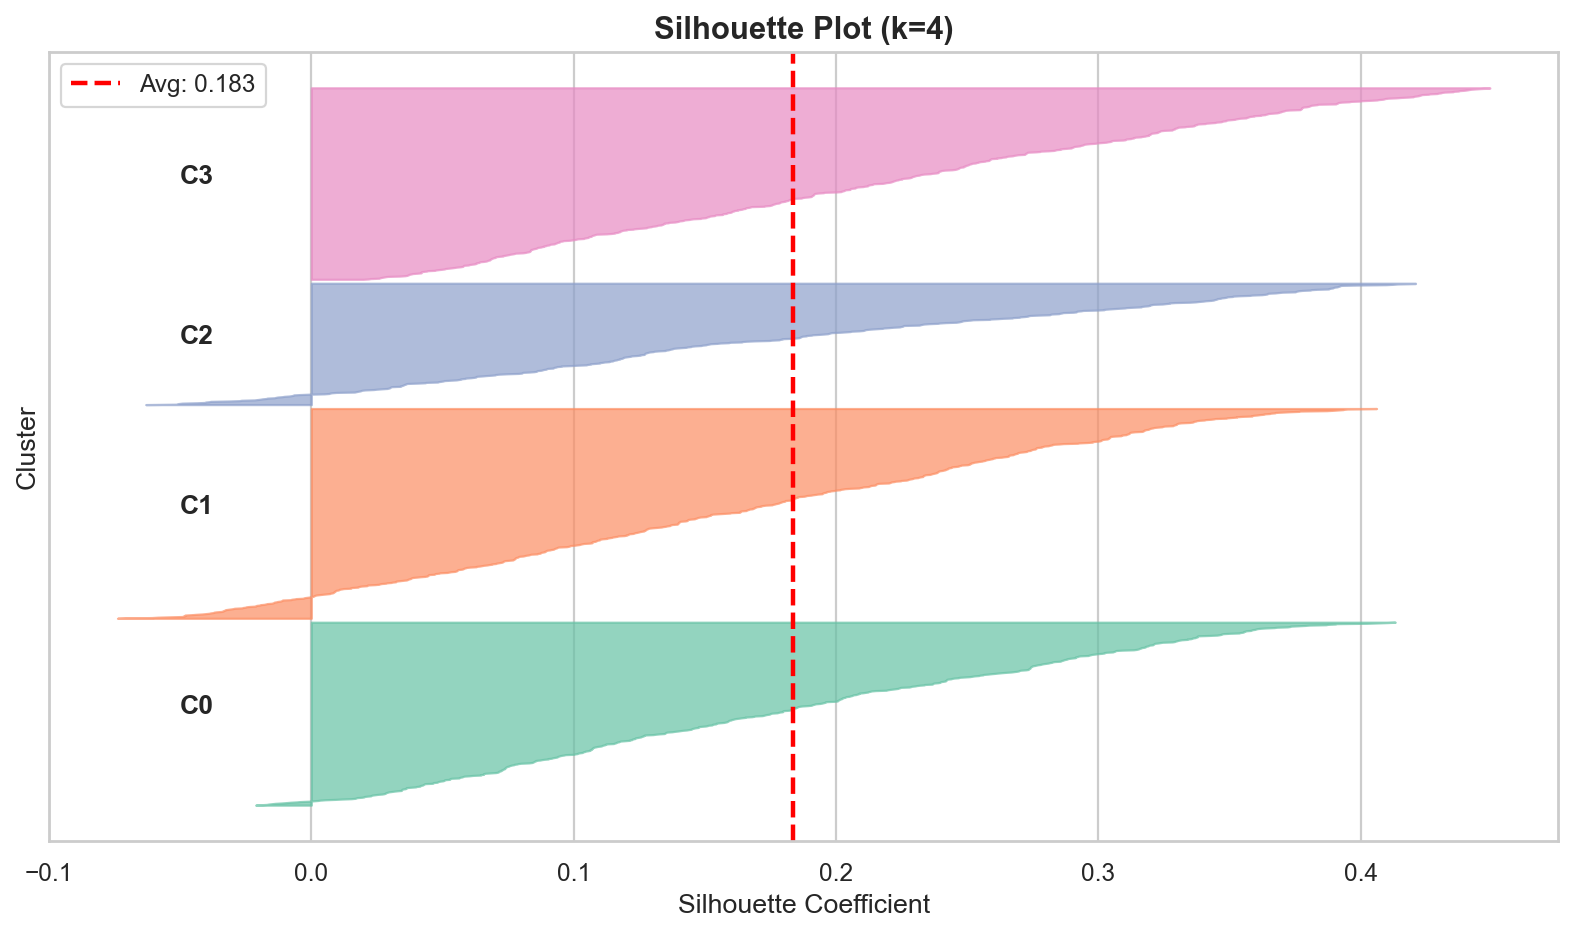

In [13]:
# Calculate silhouette values for each sample
silhouette_vals = silhouette_samples(X_scaled, best_labels)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(best_k):
    # Get silhouette values for this cluster
    cluster_silhouette_vals = silhouette_vals[best_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = colors[i]
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}', fontweight='bold')
    
    y_lower = y_upper + 10

# Add average silhouette score line
ax.axvline(x=best_sil, color='red', linestyle='--', linewidth=2, label=f'Avg: {best_sil:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Silhouette Plot (k={best_k})', fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.legend(loc='best')

plt.tight_layout()
plt.show()

### 6.3 Profile Heatmap

Visualizes the combined profile (demographics + features) as a heatmap.

**Color coding:**
- Demographics (Age, Sex): No color (displayed as text only)
- Features (EF/TD): Blue-Red gradient based on z-scores
  - Red: Above population mean
  - Blue: Below population mean

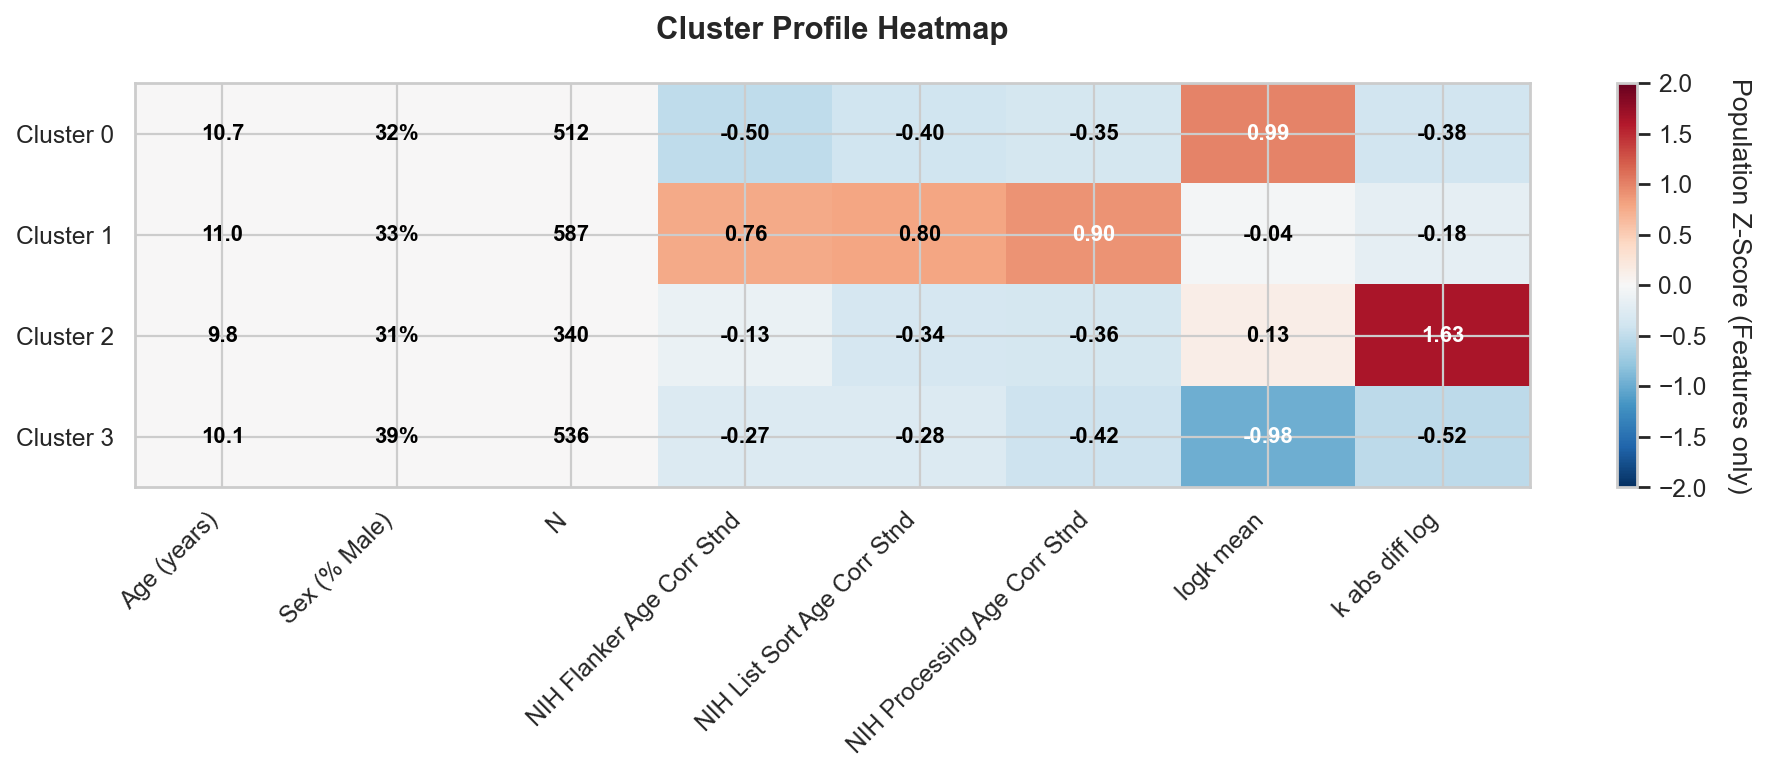

In [14]:
from matplotlib.colors import TwoSlopeNorm

# Prepare data for heatmap
heatmap_data = combined_profile.copy()

# Create a numeric matrix for coloring (only features, not demographics)
color_matrix = np.zeros_like(heatmap_data.values, dtype=float)

# Fill in z-scores for features (columns after N)
n_demo_cols = 3  # Age, Sex (% Male), N
for j in range(n_demo_cols, heatmap_data.shape[1]):
    color_matrix[:, j] = heatmap_data.iloc[:, j].values

# Set demographic columns to 0 (neutral color)
color_matrix[:, :n_demo_cols] = 0

# Create figure
fig, ax = plt.subplots(figsize=(12, 5))

# Create colormap with center at 0
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

# Plot heatmap
im = ax.imshow(color_matrix, cmap='RdBu_r', norm=norm, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(heatmap_data.shape[1]))
ax.set_yticks(np.arange(heatmap_data.shape[0]))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
ax.set_yticklabels([f'Cluster {i}' for i in heatmap_data.index])

# Add text annotations
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        
        # Format based on column type
        if j == 0:  # Age
            text = f'{value:.1f}'
        elif j == 1:  # Sex (% Male)
            text = f'{value:.0f}%'
        elif j == 2:  # N
            text = f'{int(value)}'
        else:  # Z-scores
            text = f'{value:.2f}'
        
        # Choose text color for contrast
        if abs(color_matrix[i, j]) < 0.8:
            text_color = 'black'
        else:
            text_color = 'white'
        
        ax.text(j, i, text, ha='center', va='center', 
               color=text_color, fontweight='bold', fontsize=10)

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Population Z-Score (Features only)', rotation=270, labelpad=20)

ax.set_title('Cluster Profile Heatmap', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

### 6.4 Feature Distributions by Cluster

Shows violin plots for each feature, separated by cluster. This helps visualize the distribution and overlap between clusters.

/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_22813/1117860415.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_22813/1117860415.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_22813/1117860415.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_22813/1117860415.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is dep

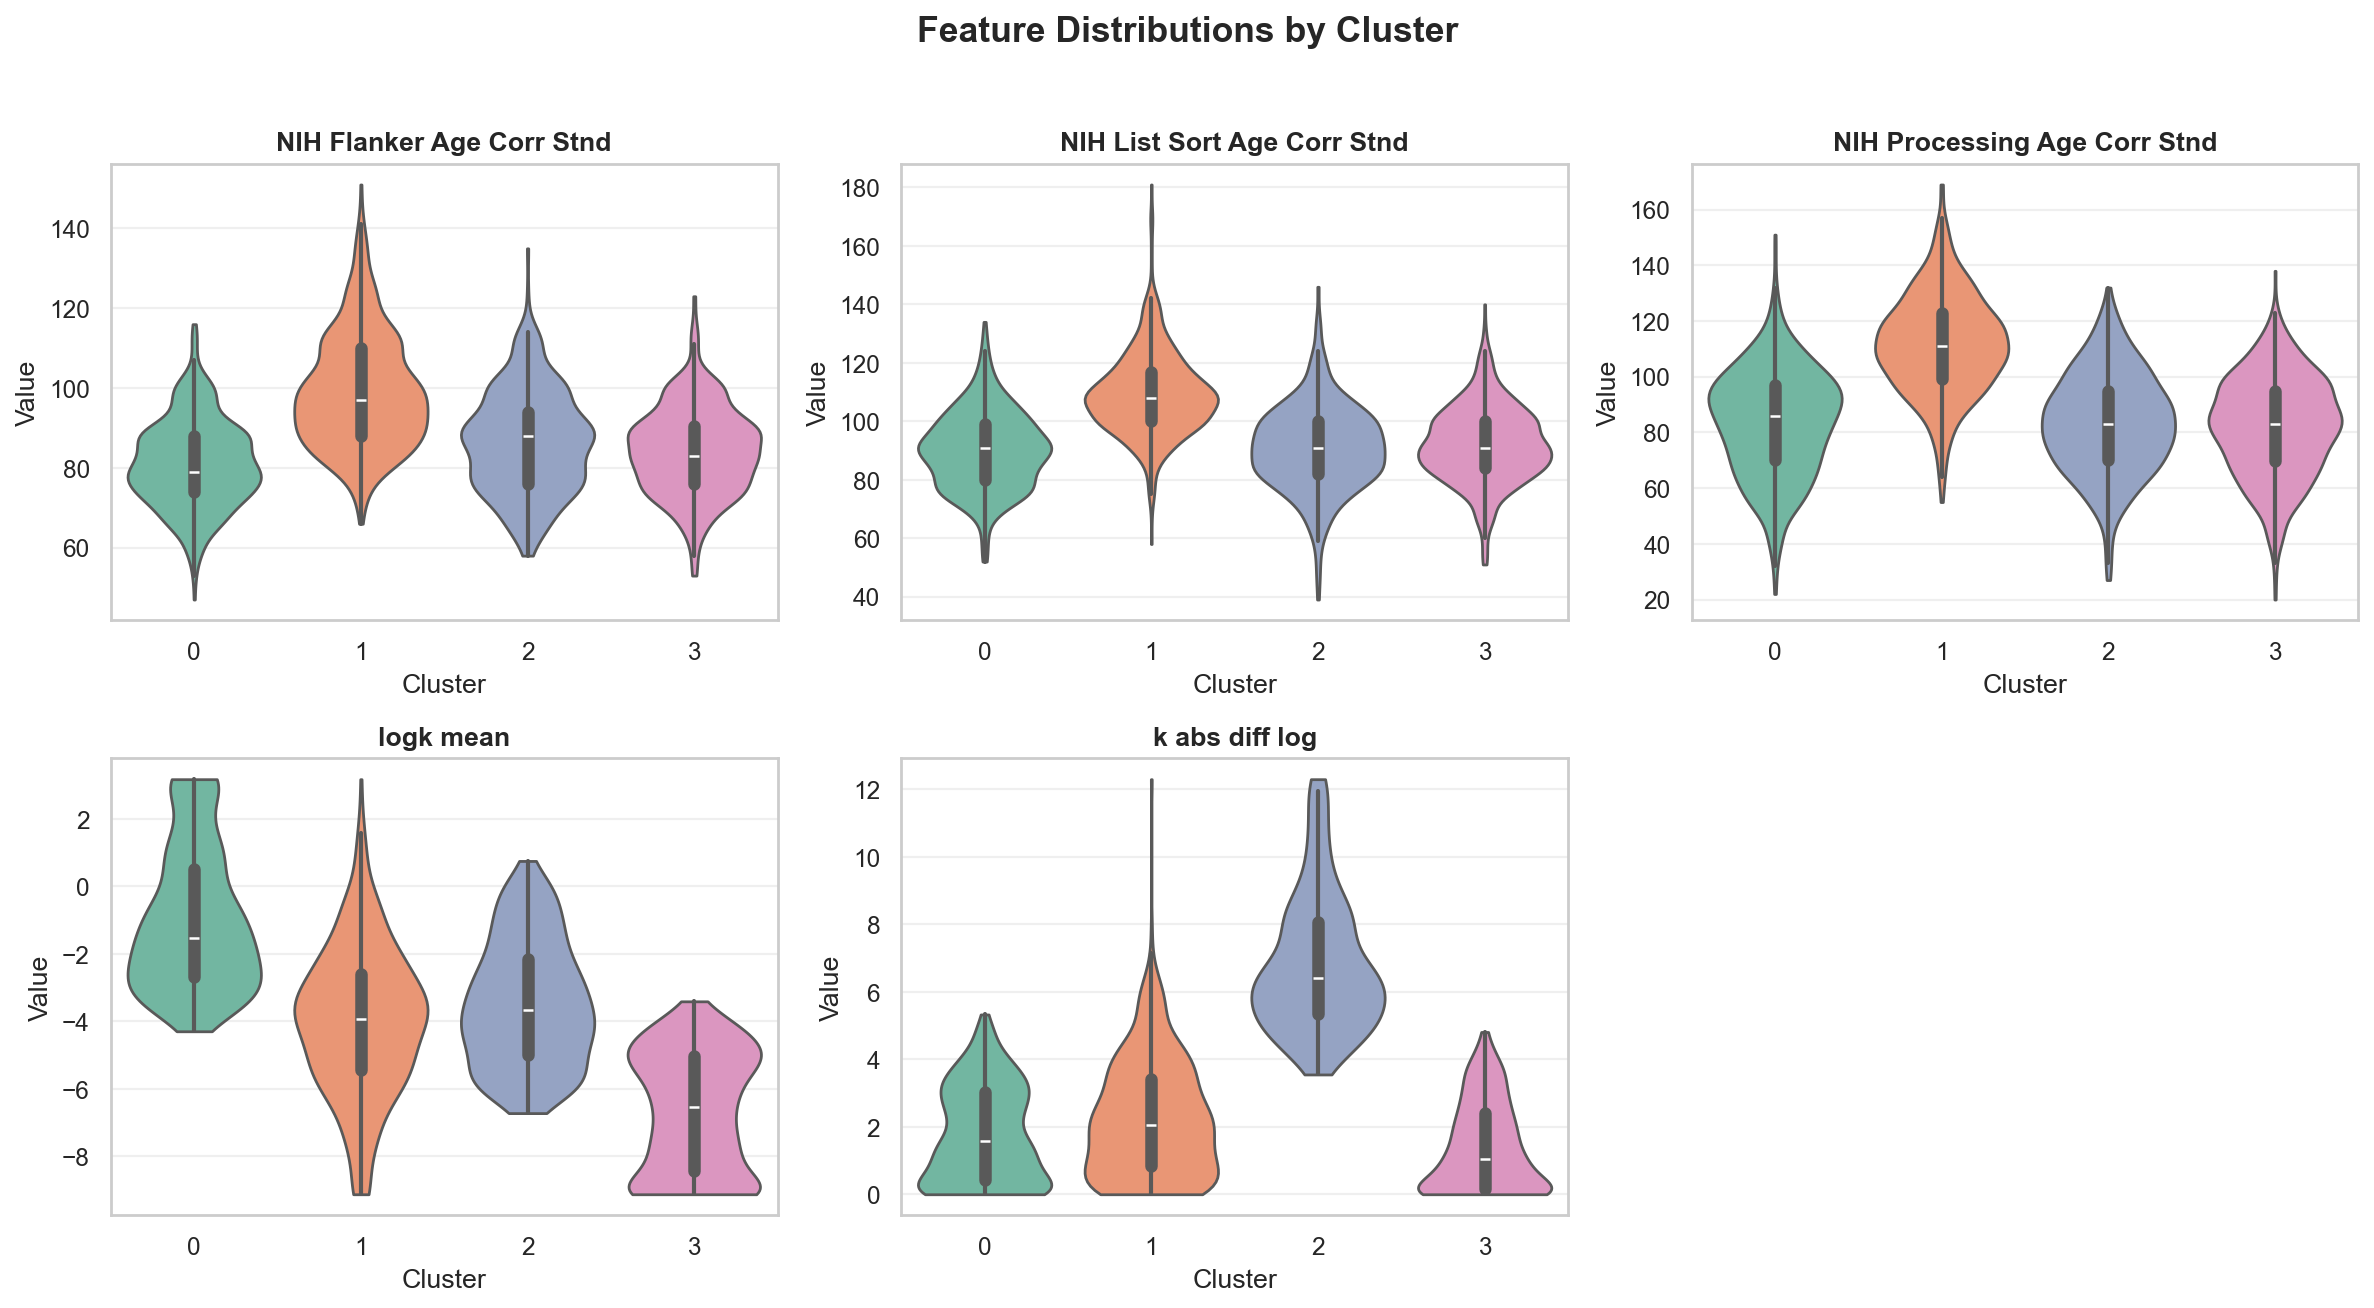

In [20]:
# Prepare data for plotting (use original units)
plot_data = profile_df[CLUSTERING_FEATURES + ['Cluster']].copy()

# Simplify feature names
plot_data.columns = [
    col.split(',')[-1].replace('_', ' ') if ',' in col else col.replace('_', ' ')
    for col in plot_data.columns
]

# Create figure with subplots
n_features = len(CLUSTERING_FEATURES)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Plot each feature
for idx, col in enumerate(plot_data.columns[:-1]):  # Exclude 'Cluster'
    ax = axes[idx]
    
    # Create violin plot
    sns.violinplot(
        data=plot_data,
        x='Cluster',
        y=col,
        palette=colors,
        ax=ax,
        inner='box',
        cut=0
    )
    
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')

# Remove empty subplot
fig.delaxes(axes[-1])

fig.suptitle('Feature Distributions by Cluster', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 6.5 Cluster Size Bar Chart

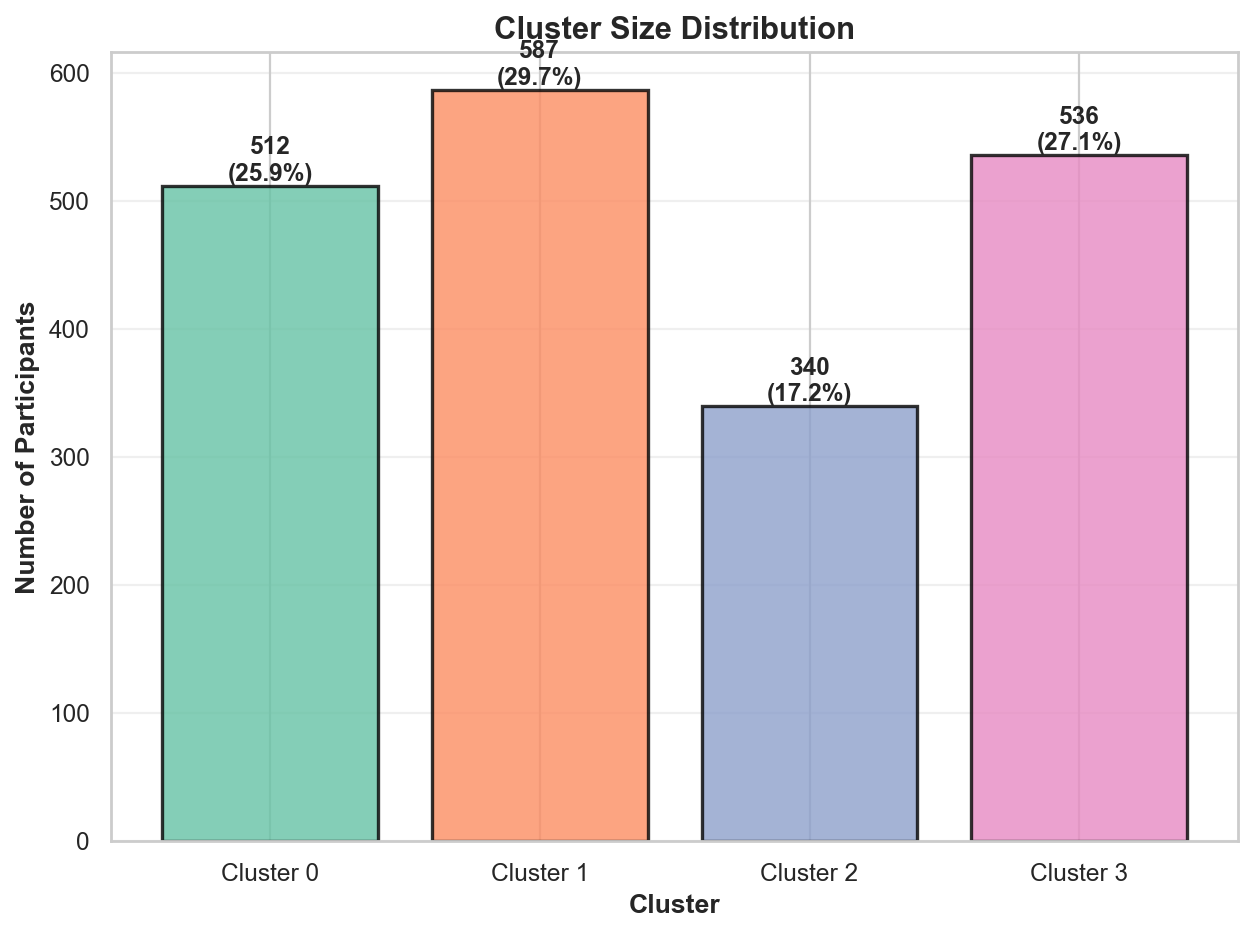

In [16]:
# Count participants per cluster
cluster_counts = pd.Series(best_labels).value_counts().sort_index()

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    cluster_counts.index,
    cluster_counts.values,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

# Add value labels on bars
for bar, count in zip(bars, cluster_counts.values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(count)}\n({count/len(best_labels)*100:.1f}%)',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=11
    )

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(cluster_counts.index)
ax.set_xticklabels([f'Cluster {i}' for i in cluster_counts.index])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6.6 Summary

In [17]:
print(f"\nDataset:")
print(f"  - Total participants: {len(df)}")
print(f"  - Features used: {len(CLUSTERING_FEATURES)}")
print(f"  - Participants clustered: {len(best_labels)}")

print(f"\nModel:")
print(f"  - Algorithm: KMeans")
print(f"  - Number of clusters (k): {best_k}")
print(f"  - Silhouette score: {best_sil:.3f}")

print(f"\nCluster Sizes:")
for i, count in cluster_counts.items():
    pct = count / len(best_labels) * 100
    print(f"  - Cluster {i}: {count:4d} participants ({pct:5.1f}%)")

print(f"\nDemographic Differences:")
for i in range(best_k):
    age = demo_profile.loc[i, 'Age (years)']
    sex = demo_profile.loc[i, 'Sex (% Male)']
    print(f"  - Cluster {i}: Age={age:.1f} yrs, Male={sex:.0f}%")

print(f"\nKey Feature Differences (Population Z-Scores):")
for feat in feature_profile.columns[:3]:  # Show top 3 features
    print(f"\n  {feat}:")
    for i in range(best_k):
        z = feature_profile.loc[i, feat]
        direction = "above" if z > 0 else "below"
        print(f"    Cluster {i}: {z:+.2f} ({direction} average)")


Dataset:
  - Total participants: 1975
  - Features used: 5
  - Participants clustered: 1975

Model:
  - Algorithm: KMeans
  - Number of clusters (k): 4
  - Silhouette score: 0.183

Cluster Sizes:
  - Cluster 0:  512 participants ( 25.9%)
  - Cluster 1:  587 participants ( 29.7%)
  - Cluster 2:  340 participants ( 17.2%)
  - Cluster 3:  536 participants ( 27.1%)

Demographic Differences:
  - Cluster 0: Age=10.7 yrs, Male=32%
  - Cluster 1: Age=11.0 yrs, Male=33%
  - Cluster 2: Age=9.8 yrs, Male=31%
  - Cluster 3: Age=10.1 yrs, Male=39%

Key Feature Differences (Population Z-Scores):

  NIH Flanker Age Corr Stnd:
    Cluster 0: -0.50 (below average)
    Cluster 1: +0.76 (above average)
    Cluster 2: -0.13 (below average)
    Cluster 3: -0.27 (below average)

  NIH List Sort Age Corr Stnd:
    Cluster 0: -0.40 (below average)
    Cluster 1: +0.80 (above average)
    Cluster 2: -0.34 (below average)
    Cluster 3: -0.28 (below average)

  NIH Processing Age Corr Stnd:
    Cluster 0: -0.3

## 7. Save Results

Save essential files for downstream analysis and presentations:
- Cluster assignments (for merging with other datasets)
- Cluster profiles (for reporting)
- Model objects (for assigning new participants)
- High-quality figures (300 DPI for presentations)

In [22]:
import json
import joblib
from datetime import datetime

print("="*70)
print("SAVING RESULTS")
print("="*70)

# Set up directories
RESULTS_DIR = Path("results/kmeans_model")
FIGURES_DIR = Path("results/kmeans_figures")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Results: {RESULTS_DIR.absolute()}")
print(f"✓ Figures: {FIGURES_DIR.absolute()}")

# --- 1. Cluster assignments (for downstream analysis) ---
ID_COL = "_EID" if "_EID" in df.columns else "EID"
assignments = pd.DataFrame({
    ID_COL: df[ID_COL],
    'cluster': best_labels
})
assignments.to_csv(RESULTS_DIR / "cluster_assignments.csv", index=False)
print(f"\n✓ Saved: cluster_assignments.csv ({len(assignments)} participants)")

# --- 2. Cluster profiles (for papers/reports) ---
combined_profile.to_csv(RESULTS_DIR / "cluster_profiles.csv")
print(f"✓ Saved: cluster_profiles.csv")

# --- 3. Model objects (for assigning new participants) ---
joblib.dump(best_model, RESULTS_DIR / "kmeans_model.joblib")
joblib.dump(preprocessor, RESULTS_DIR / "preprocessor.joblib")
print(f"✓ Saved: model files (kmeans_model.joblib, preprocessor.joblib)")

# --- 4. High-quality figures (300 DPI for presentations) ---
print(f"\n✓ Saving high-resolution figures (300 DPI)...")

# PCA scatter
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
for i in range(best_k):
    mask = best_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], 
              label=f'Cluster {i}', alpha=0.6, s=50, 
              edgecolors='white', linewidth=0.5)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='X',
          s=300, edgecolors='white', linewidth=2, zorder=10)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title(f'KMeans Clustering (k={best_k})', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "pca_scatter.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  → pca_scatter.png")

# Profile heatmap
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
im = ax.imshow(color_matrix, cmap='RdBu_r', norm=norm, aspect='auto')
ax.set_xticks(np.arange(heatmap_data.shape[1]))
ax.set_yticks(np.arange(heatmap_data.shape[0]))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels([f'Cluster {i}' for i in heatmap_data.index], fontsize=10)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        if j == 0: text = f'{value:.1f}'
        elif j == 1: text = f'{value:.0f}%'
        elif j == 2: text = f'{int(value)}'
        else: text = f'{value:.2f}'
        text_color = 'white' if abs(color_matrix[i, j]) > 0.8 else 'black'
        ax.text(j, i, text, ha='center', va='center',
               color=text_color, fontweight='bold', fontsize=9)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Population Z-Score', rotation=270, labelpad=20)
ax.set_title('Cluster Profiles', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "profile_heatmap.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  → profile_heatmap.png")

# Cluster sizes
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
bars = ax.bar(cluster_counts.index, cluster_counts.values, color=colors,
             alpha=0.8, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars, cluster_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
           f'{int(count)}\n({count/len(best_labels)*100:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Participants', fontsize=12, fontweight='bold')
ax.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(cluster_counts.index)
ax.set_xticklabels([f'C{i}' for i in cluster_counts.index])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cluster_sizes.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()
print(f"  → cluster_sizes.png")

# --- 5. Summary info (lightweight JSON) ---
metadata = {
    "date": datetime.now().strftime("%Y-%m-%d"),
    "n_clusters": int(best_k),
    "silhouette": float(best_sil),
    "n_participants": int(len(df)),
    "features": CLUSTERING_FEATURES,
    "cluster_sizes": {int(k): int(v) for k, v in cluster_counts.items()}
}
with open(RESULTS_DIR / "clustering_summary.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"\n✓ Saved: clustering_summary.json")

print("\n" + "="*70)
print("SAVE COMPLETE")
print("="*70)
print(f"\n📁 Results: {RESULTS_DIR.absolute()}")
print(f"   • cluster_assignments.csv (merge with other data)")
print(f"   • cluster_profiles.csv (for reporting)")
print(f"   • kmeans_model.joblib + preprocessor.joblib (predictions)")
print(f"   • clustering_summary.json (metadata)")
print(f"\n📊 Figures: {FIGURES_DIR.absolute()}")
print(f"   • pca_scatter.png (300 DPI)")
print(f"   • profile_heatmap.png (300 DPI)")
print(f"   • cluster_sizes.png (300 DPI)")
print(f"\n✅ Ready for downstream analysis!")

SAVING RESULTS

✓ Results: /Users/yizj/Desktop/hbn_project/results/kmeans_model
✓ Figures: /Users/yizj/Desktop/hbn_project/results/kmeans_figures

✓ Saved: cluster_assignments.csv (1975 participants)
✓ Saved: cluster_profiles.csv
✓ Saved: model files (kmeans_model.joblib, preprocessor.joblib)

✓ Saving high-resolution figures (300 DPI)...
  → pca_scatter.png
  → profile_heatmap.png
  → cluster_sizes.png

✓ Saved: clustering_summary.json

SAVE COMPLETE

📁 Results: /Users/yizj/Desktop/hbn_project/results/kmeans_model
   • cluster_assignments.csv (merge with other data)
   • cluster_profiles.csv (for reporting)
   • kmeans_model.joblib + preprocessor.joblib (predictions)
   • clustering_summary.json (metadata)

📊 Figures: /Users/yizj/Desktop/hbn_project/results/kmeans_figures
   • pca_scatter.png (300 DPI)
   • profile_heatmap.png (300 DPI)
   • cluster_sizes.png (300 DPI)

✅ Ready for downstream analysis!
